### MACHINE LEARNING - PROJECT SUBMISSION
### Project: Predicting Players Rating

In this project you are going to predict the overall rating of soccer player based on their attributes such as 'crossing', 'finishing etc.

The dataset you are going to use is from European Soccer Database (https://www.kaggle.com/hugomathien/soccer) has more than 25,000 matches and more than 10,000 players for European professional soccer seasons from 2008 to 2016.

Download the data in the same folder and run the following commmand to get it in the environment

#### About the Dataset

The ultimate Soccer database for data analysis and machine learning

The dataset comes in the form of an SQL database and contains statistics of about 25,000 football matches, from the top football league of 11 European Countries. It covers seasons from 2008 to
2016 and contains match statistics (i.e: scores, corners, fouls etc...) as well as the team formations, with player names and a pair of coordinates to indicate their position on the pitch.

    +25,000 matches
    +10,000 players
    11 European Countries with their lead championship
    Seasons 2008 to 2016
    Players and Teams' attributes* sourced from EA Sports' FIFA video game series, including the weekly updates
    Team line up with squad formation (X, Y coordinates)
    Betting odds from up to 10 providers
    Detailed match events (goal types, possession, corner, cross, fouls, cards etc...) for +10,000 matches

The dataset also has a set of about 35 statistics for each player, derived from EA Sports' FIFA video games. It is not just the stats that come with a new version of the game but also the weekly
updates. So for instance if a player has performed poorly over a period of time and his stats get impacted in FIFA, you would normally see the same in the dataset.

In [3]:
import numpy as np
import pandas as pd
import sqlite3
%matplotlib notebook
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, RandomizedSearchCV
from sklearn.pipeline import make_pipeline

import pickle

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Create your connection
cnx = sqlite3.connect('database.sqlite')
dd = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", cnx)

In [5]:
print(dd)

                name
0    sqlite_sequence
1  Player_Attributes
2             Player
3              Match
4             League
5            Country
6               Team
7    Team_Attributes


In [6]:
df = pd.read_sql_query("SELECT * FROM Player_Attributes", cnx)

In [7]:
df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [8]:
target = df.pop('overall_rating')

In [9]:
df.shape

(183978, 41)

In [10]:
target.head()

0    67.0
1    67.0
2    62.0
3    61.0
4    61.0
Name: overall_rating, dtype: float64

#### Imputing target function

In [11]:
target.isnull().values.sum()

836

There are 836 missing values

In [12]:
target.describe()

count    183142.000000
mean         68.600015
std           7.041139
min          33.000000
25%          64.000000
50%          69.000000
75%          73.000000
max          94.000000
Name: overall_rating, dtype: float64

<IPython.core.display.Javascript object>


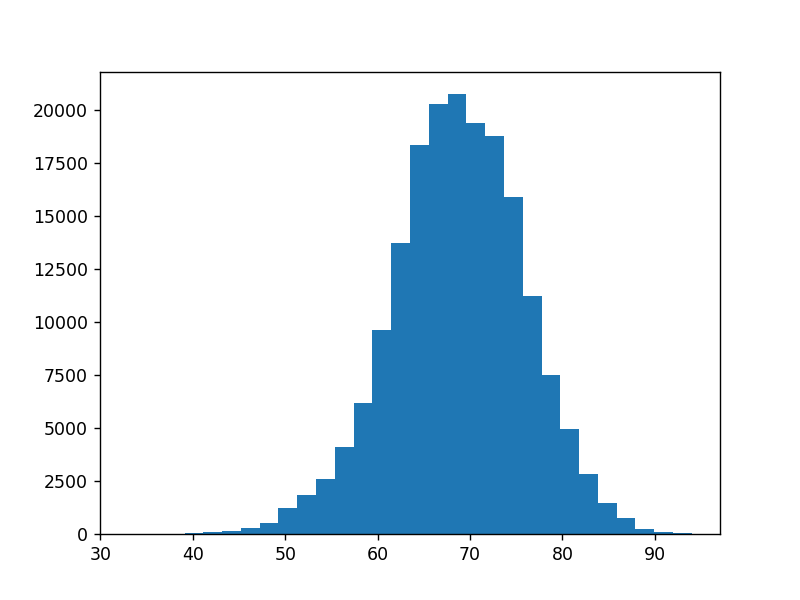

(array([7.0000e+00, 6.0000e+00, 2.0000e+01, 6.5000e+01, 9.4000e+01,
        1.4200e+02, 2.9400e+02, 5.2600e+02, 1.2510e+03, 1.8450e+03,
        2.5780e+03, 4.0870e+03, 6.1890e+03, 9.6500e+03, 1.3745e+04,
        1.8366e+04, 2.0310e+04, 2.0773e+04, 1.9382e+04, 1.8784e+04,
        1.5915e+04, 1.1254e+04, 7.5250e+03, 4.9470e+03, 2.8290e+03,
        1.4590e+03, 7.4800e+02, 2.2800e+02, 8.4000e+01, 3.9000e+01]),
 array([33.        , 35.03333333, 37.06666667, 39.1       , 41.13333333,
        43.16666667, 45.2       , 47.23333333, 49.26666667, 51.3       ,
        53.33333333, 55.36666667, 57.4       , 59.43333333, 61.46666667,
        63.5       , 65.53333333, 67.56666667, 69.6       , 71.63333333,
        73.66666667, 75.7       , 77.73333333, 79.76666667, 81.8       ,
        83.83333333, 85.86666667, 87.9       , 89.93333333, 91.96666667,
        94.        ]),
 <a list of 30 Patch objects>)

In [13]:
plt.hist(target, 30, range=(33, 94))

It is almost a normal distribution so we can impute mean value for missing values

In [14]:
y = target.fillna(target.mean())

In [15]:
y.isnull().values.any()

False

#### Data Exploration

In [16]:
df.columns

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'potential',
       'preferred_foot', 'attacking_work_rate', 'defensive_work_rate',
       'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'free_kick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes'],
      dtype='object')

In [17]:
for col in df.columns:
    unique_cat = len(df[col].unique())
    print("{col}--> {unique_cat}..{typ}".format(col=col, unique_cat=unique_cat, typ=df[col].dtype))

id--> 183978..int64
player_fifa_api_id--> 11062..int64
player_api_id--> 11060..int64
date--> 197..object
potential--> 57..float64
preferred_foot--> 3..object
attacking_work_rate--> 9..object
defensive_work_rate--> 20..object
crossing--> 96..float64
finishing--> 98..float64
heading_accuracy--> 97..float64
short_passing--> 96..float64
volleys--> 94..float64
dribbling--> 98..float64
curve--> 93..float64
free_kick_accuracy--> 98..float64
long_passing--> 96..float64
ball_control--> 94..float64
acceleration--> 87..float64
sprint_speed--> 86..float64
agility--> 82..float64
reactions--> 79..float64
balance--> 82..float64
shot_power--> 97..float64
jumping--> 80..float64
stamina--> 85..float64
strength--> 83..float64
long_shots--> 97..float64
aggression--> 92..float64
interceptions--> 97..float64
positioning--> 96..float64
vision--> 98..float64
penalties--> 95..float64
marking--> 96..float64
standing_tackle--> 96..float64
sliding_tackle--> 95..float64
gk_diving--> 94..float64
gk_handling--> 91..

There are only four features that have the type 'object'.  The feature named 'date' has no significance in this problem so we can ignore it and perform one hot encoding on the rest of the 3 features.

In [18]:
dummy_df = pd.get_dummies(df, columns=['preferred_foot', 'attacking_work_rate', 'defensive_work_rate'])
dummy_df.head()

,id,player_fifa_api_id,player_api_id,date,potential,crossing,finishing,heading_accuracy,short_passing,volleys,...,defensive_work_rate_9,defensive_work_rate__0,defensive_work_rate_ean,defensive_work_rate_es,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,defensive_work_rate_o,defensive_work_rate_ormal,defensive_work_rate_tocky
0,1,218353,505942,2016-02-18 00:00:00,71.0,49.0,44.0,71.0,61.0,44.0,...,0,0,0,0,0,0,1,0,0,0
1,2,218353,505942,2015-11-19 00:00:00,71.0,49.0,44.0,71.0,61.0,44.0,...,0,0,0,0,0,0,1,0,0,0
2,3,218353,505942,2015-09-21 00:00:00,66.0,49.0,44.0,71.0,61.0,44.0,...,0,0,0,0,0,0,1,0,0,0
3,4,218353,505942,2015-03-20 00:00:00,65.0,48.0,43.0,70.0,60.0,43.0,...,0,0,0,0,0,0,1,0,0,0
4,5,218353,505942,2007-02-22 00:00:00,65.0,48.0,43.0,70.0,60.0,43.0,...,0,0,0,0,0,0,1,0,0,0


In [19]:
X = dummy_df.drop(['id', 'date'], axis=1)

#### Feature selection

As tree model doesn't get affected by missing values present in data set, feature selection by SelectFromModel can not be done on datasets that carries null values. Therefore, we should also perform imputation on dataset.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [21]:
# Imputing null value of each column with the mean of that column
imput = Imputer()
X_train = imput.fit_transform(X_train)
X_test = imput.fit_transform(X_test)

In [22]:
# Finding feature_importance for feature selection. This will help us decide threshold value.
model = XGBRegressor()
model.fit(X_train, y_train)
print(model.feature_importances_)

[13:25:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.05115651 0.02897777 0.13911739 0.02826106 0.00595768 0.04332646
 0.01590659 0.         0.01287898 0.         0.         0.00348626
 0.13141693 0.00436716 0.0058711  0.0065089  0.16110069 0.
 0.05513685 0.0040621  0.00863542 0.03761797 0.00898127 0.0139806
 0.01894557 0.02671051 0.0015188  0.         0.03219567 0.0530614
 0.00176505 0.02725989 0.02712863 0.01008714 0.02617038 0.00840923
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


In [23]:
selection = SelectFromModel(model, threshold=0.01, prefit=True)

select_X_train = selection.transform(X_train)
select_X_test = selection.transform(X_test)

In [24]:
select_X_train.shape

(137983, 20)

#### Training different models

#### 1. Linear Regression

In [25]:
pipe = make_pipeline(StandardScaler(),LinearRegression())

cv = ShuffleSplit(random_state=0)   # Defining type of cross_validation(shuffle spliting)

param_grid = {'linearregression__n_jobs': [-1]}     # Parameters for model tunning

grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv)

In [26]:
grid.fit(select_X_train, y_train)          #training

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size='default',
       train_size=None),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'linearregression__n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [27]:
grid.best_params_

{'linearregression__n_jobs': -1}

In [28]:
lin_reg = pickle.dumps(grid)

#### 2. Decision Tree

In [29]:
pipe = make_pipeline(StandardScaler(), DecisionTreeRegressor(criterion='mse', random_state=0))  # Estimator

cv = ShuffleSplit(n_splits=10, random_state=42)  # Cross validation

param_grid = {'decisiontreeregressor__max_depth': [3, 5, 7, 9, 13]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv)

In [30]:
grid.fit(select_X_train, y_train)   # Training

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size='default',
       train_size=None),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('decisiontreeregressor', DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'decisiontreeregressor__max_depth': [3, 5, 7, 9, 13]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [31]:
grid.best_params_

{'decisiontreeregressor__max_depth': 13}

In [32]:
Dectree_reg = pickle.dumps(grid)

#### 3. Random Forest

In [33]:
pipe = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=500, random_state=123))

cv = ShuffleSplit(test_size=0.2, random_state=0)

param_grid = {'randomforestregressor__max_features':['sqrt', 'log2', 10],'randomforestregressor__max_depth':[9, 11, 13]}                 

grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv)

In [34]:
grid.fit(select_X_train, y_train)   # Training

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decr...tors=500, n_jobs=None,
           oob_score=False, random_state=123, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'randomforestregressor__max_features': ['sqrt', 'log2', 10], 'randomforestregressor__max_depth': [9, 11, 13]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [35]:
grid.best_params_

{'randomforestregressor__max_depth': 13,
 'randomforestregressor__max_features': 10}

In [36]:
Randfor_reg = pickle.dumps(grid)

#### 4. Xgboost regressor

In [37]:
pipe = make_pipeline(StandardScaler(), XGBRegressor(n_estimators= 500, random_state=42))

cv = ShuffleSplit(n_splits=10, random_state=0)

param_grid = {'xgbregressor__max_depth': [5, 7], 'xgbregressor__learning_rate': [0.1, 0.3]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv, n_jobs= -1)

In [38]:
grid.fit(select_X_train, y_train)

[02:27:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size='default',
       train_size=None),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgbregressor', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
      ...lpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'xgbregressor__max_depth': [5, 7], 'xgbregressor__learning_rate': [0.1, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [39]:
grid.best_params_

{'xgbregressor__learning_rate': 0.3, 'xgbregressor__max_depth': 7}

In [40]:
xgbreg = pickle.dumps(grid)

#### Conclusion

In [41]:
lin_reg = pickle.loads(lin_reg)
Dectree_reg = pickle.loads(Dectree_reg)
Randfor_reg = pickle.loads(Randfor_reg)
xgbreg = pickle.loads(xgbreg)

[02:30:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [42]:
print("""Linear Regressor accuracy is {lin}
DecisionTree Regressor accuracy is {Dec}
RandomForest regressor accuracy is {ran}
XGBoost regressor accuracy is {xgb}""".format(lin=lin_reg.score(select_X_test, y_test), Dec=Dectree_reg.score(select_X_test, y_test), ran=Randfor_reg.score(select_X_test, y_test), xgb=xgbreg.score(select_X_test, y_test)))

Linear Regressor accuracy is 0.8536768959300971
DecisionTree Regressor accuracy is 0.9270795886776287
RandomForest regressor accuracy is 0.9615008079149985
XGBoost regressor accuracy is 0.9797578207551222


After comparing above models, XGBoost appeas to be the best among other models as the accuracy is at 98%